## NOTE

This needs work, the subsampling cannot be combined across chromosomes as the selected samples were not consistent across chromosomes. 

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from geopy.geocoders import GoogleV3
from geopy.distance import geodesic
geolocator = GoogleV3()

In [3]:
from itertools import combinations
import time
import functools
import sys

In [4]:
release_dir = "/kwiat/vector/ag1000g/release/phase2.AR1"

In [5]:
meta_fn = os.path.join(release_dir, "samples/samples.meta.txt")

In [6]:
meta = pd.read_table(meta_fn)

In [7]:
ibd_fn = "/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/{chrom}/{pop}.ibd"
samp_fn = "/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/{chrom}/{pop}.samples.txt"

In [8]:
subsets = ["sub{0}".format(i) for i in range(10)]

In [9]:
os.path.isfile(ibd_fn.format(chrom="2L", pop="sub0"))  

True

In [10]:
populations = meta.population.unique()
populations

array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'UGgam', 'GM', 'GW', 'KE',
       'CMgam', 'FRgam', 'GQgam', 'AOcol', 'GAgam', 'GNgam', 'GNcol',
       'CIcol'], dtype=object)

In [11]:
len(list(combinations(range(250), 2)))

31125

In [12]:
IBDCOLS = ["sample1", "i1", "sample2", "i2", "chrom", "start", "end", "LOD"]

def loadIBD(chrom, pop, cutoff):

    ibdframe = pd.read_table(
        ibd_fn.format(chrom=chrom, pop=pop), 
        names=IBDCOLS)

    ibdframe["tot_len"] = ibdframe.end - ibdframe.start
    ibdframe = ibdframe.loc[ibdframe.tot_len >= cutoff]
    ibdframe = ibdframe.set_index(["sample1", "sample2"])
    
    return ibdframe


def get_IBD(chrom, pop, cutoff=100000):
        
    if not isinstance(chrom, str):
        f = {c: get_IBD(c, pop, cutoff) for c in chrom}
        f = pd.concat(f).groupby(level=[1, 2]).aggregate(sum)
        
    else:
        
        ibddf = loadIBD(chrom, pop, cutoff)
        from itertools import combinations

        with open(samp_fn.format(chrom=chrom, pop=pop)) as fh:
            samples = [x.strip() for x in fh.readlines()]
            
        all_combs = list(combinations(samples, 2))
       
        g = ibddf.groupby(level=[0, 1])
        ibd_sum = g.tot_len.aggregate(np.sum)
        ibd_count = g.tot_len.count()
        
        # vindex is all possible combinations
        vindex = pd.MultiIndex.from_tuples(all_combs, names=["Sample1", "Sample2"])

        f = pd.concat([ibd_sum, ibd_count], axis=1).reindex(index=vindex, fill_value=0)
        f.columns = ["IBDsum", "IBDcount"]
    
    return f

In [13]:
seq_ids = ("3L", )

In [14]:
ibd_dict = {pop: get_IBD(seq_ids, pop, 10000) for pop in subsets}

In [15]:
all_pop_sum = pd.concat(ibd_dict, names=["subsets"])
all_pop_sum.max(0)

IBDsum      41946751
IBDcount         270
dtype: int64

In [16]:
all_pop_sum.shape

(311250, 2)

In [17]:
# 311k vs 1.2m

In [18]:
a, b = all_pop_sum.idxmax(0)

In [19]:
all_pop_sum.loc[a]

IBDsum      41946751
IBDcount           1
Name: (sub3, AK0081-C, AK0073-C), dtype: int64

In [20]:
all_pop_sum.sort_values("IBDsum", ascending=False).head(10).IBDsum * 1e-6

subsets  Sample1   Sample2 
sub3     AK0104-C  AK0088-C    41.946751
         AK0081-C  AK0073-C    41.946751
sub1     AK0060-C  AK0104-C    41.946723
sub7     AK0127-C  AK0082-C    41.946712
         AK0119-C  AK0106-C    41.946712
sub2     AN0020-C  AN0169-C    41.946710
         AN0142-C  AN0169-C    41.946710
                   AN0020-C    41.946710
sub5     AR0001-C  AR0008-C    41.946710
         AK0117-C  AK0095-C    41.946710
Name: IBDsum, dtype: float64

## Find locations lat/lon

In [21]:
def locate_region(string):
    
    try:
        address, (latitude, longitude) = geolocator.geocode(string)
    except:
        time.sleep(1)
        latitude, longitude = locate_region(string)
        
    return latitude, longitude

In [22]:
f = meta[["region", "country"]].drop_duplicates().reset_index(drop=True)

locations = f.apply(", ".join, axis=1).apply(locate_region)

f["latlon"] = locations
f = f.set_index(["region", "country"])

In [23]:
mm = pd.merge(
    meta, 
    f.reset_index(), 
    on=["region", "country"]).set_index("ox_code")

In [24]:
mm["latlon"].sample(20)

ox_code
AV0027-C          (12.4894021, -13.3067562)
AN0236-C     (7.369721999999999, 12.354722)
AC0156-C                (0.77578, 34.01466)
AC0185-C                (0.77578, 34.01466)
AB0167-C                  (11.9, -2.333333)
AQ0015-C     (3.6198322, 8.748116699999999)
AK0086-C           (-3.5106508, 39.9093269)
AJ0134-C          (11.9438068, -15.6441852)
AS0078-C             (0.4161976, 9.4672676)
AY0064-C    (5.904262699999999, -4.8261424)
AY0015-C    (5.904262699999999, -4.8261424)
AK0088-C           (-3.5106508, 39.9093269)
AC0128-C                (0.77578, 34.01466)
AN0194-C              (3.916667, 13.883333)
AY0016-C    (5.904262699999999, -4.8261424)
AJ0095-C          (11.8969747, -15.5914071)
AG0181-C            (13.443182, -15.310139)
AN0169-C              (3.916667, 13.883333)
AN0027-C             (5.7468834, 14.440307)
AN0065-C                       (4.45, 12.9)
Name: latlon, dtype: object

In [25]:
import functools

In [26]:
@functools.lru_cache()
def compute_distance(latlon_a, latlon_b):
    if latlon_a == latlon_b:
        return 0.0
    else:
        return geodesic(latlon_a, latlon_b).km

In [27]:
# Here need to assign a unique value for each_region/country. Use index of f
# Then distances becomes a simpler multiindex.
q = pd.merge(
    all_pop_sum.reset_index(), 
    mm[["latlon"]], 
    left_on="Sample1", 
    right_index=True)

analysis_df = pd.merge(
    q, 
    mm[["latlon"]], 
    left_on="Sample2", 
    right_index=True)

In [28]:
analysis_df["distance_km"] = analysis_df.apply(
    lambda y: compute_distance(y.latlon_x, y.latlon_y), 1)

/home/njh/miniconda3/envs/ag1k/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


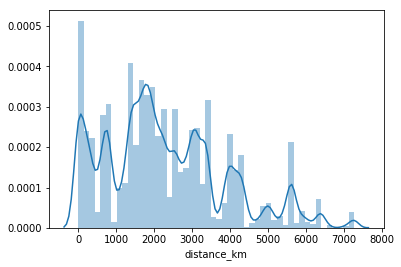

In [29]:
sns.distplot(analysis_df.distance_km)

## Summaries of data

- Plot IBDsum vs geographical distance.

- Come up with a population level sharing metric for each pair- eg CMS vs KE. Draw lines for thickness between them.

- Divide into categories, ie West/East and plot W/W E/E E/W excluding same pops?

In [30]:
bins = [-0.01, 0.1, 100] + np.arange(1000, analysis_df.distance_km.max() + 1000, 1000).tolist()

In [31]:
analysis_df["distance_bin"] = pd.cut(analysis_df.distance_km, bins=bins)

In [32]:
analysis_df.shape

(311250, 9)

In [33]:
analysis_df.head()

,subsets,Sample1,Sample2,IBDsum,IBDcount,latlon_x,latlon_y,distance_km,distance_bin
0,sub0,AA0040-C,AA0048-C,0,0,"(5.6069746, -1.5450766)","(5.6731273, -0.1663851)",152.912238,"(100.0, 1000.0]"
172,sub0,AA0042-C,AA0048-C,0,0,"(4.9015794, -1.7830973)","(5.6731273, -0.1663851)",198.483367,"(100.0, 1000.0]"
442,sub0,AA0049-C,AA0048-C,24716,1,"(5.6731273, -0.1663851)","(5.6731273, -0.1663851)",0.000000,"(-0.01, 0.1]"
555,sub0,AA0056-C,AA0048-C,11668,1,"(4.9015794, -1.7830973)","(5.6731273, -0.1663851)",198.483367,"(100.0, 1000.0]"
781,sub0,AA0061-C,AA0048-C,4485340,19,"(5.6731273, -0.1663851)","(5.6731273, -0.1663851)",0.000000,"(-0.01, 0.1]"


In [34]:
# downsample based on bins
grp = analysis_df.groupby("distance_bin")

In [35]:
analysis_df.distance_bin.value_counts()

(1000.0, 2000.0]    84815
(2000.0, 3000.0]    55935
(100.0, 1000.0]     52657
(3000.0, 4000.0]    49739
(4000.0, 5000.0]    24467
(-0.01, 0.1]        18126
(5000.0, 6000.0]    16337
(6000.0, 7000.0]     4685
(0.1, 100.0]         2439
(7000.0, 8000.0]     2050
Name: distance_bin, dtype: int64

In [36]:
n = 8300
ds = grp.apply(lambda y: y.sample(min(n, y.shape[0]))).reset_index(drop=True)

In [37]:
ds.distance_bin.value_counts()

(5000.0, 6000.0]    8300
(4000.0, 5000.0]    8300
(3000.0, 4000.0]    8300
(2000.0, 3000.0]    8300
(1000.0, 2000.0]    8300
(100.0, 1000.0]     8300
(-0.01, 0.1]        8300
(6000.0, 7000.0]    4685
(0.1, 100.0]        2439
(7000.0, 8000.0]    2050
Name: distance_bin, dtype: int64

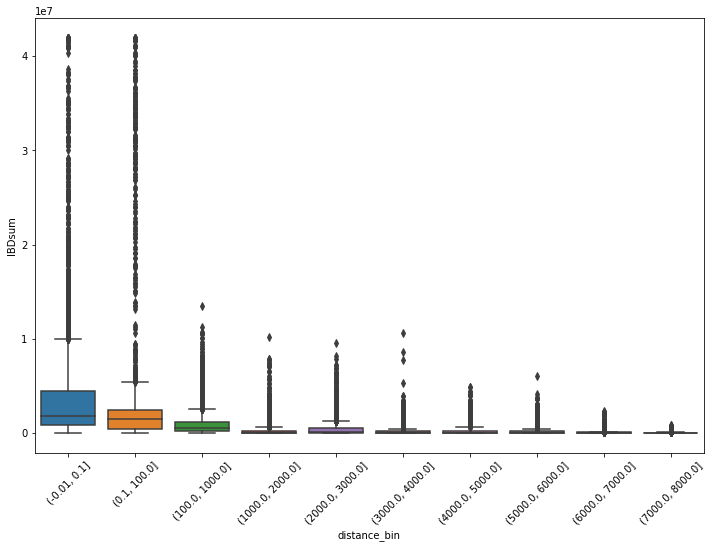

In [38]:
f = plt.figure(figsize=(12, 8))
g = sns.boxplot(y="IBDsum", x="distance_bin", data=ds)
for item in g.get_xticklabels():
    item.set_rotation(45)

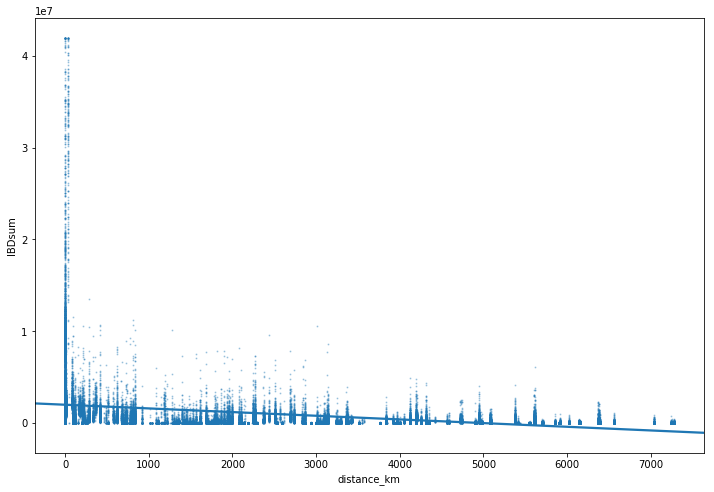

In [39]:
f = plt.figure(figsize=(12, 8))
sns.regplot("distance_km", "IBDsum", data=ds, scatter_kws={'alpha':0.3, 's':1})

In [40]:
n_bins = len(bins)

In [41]:
n_bins

11

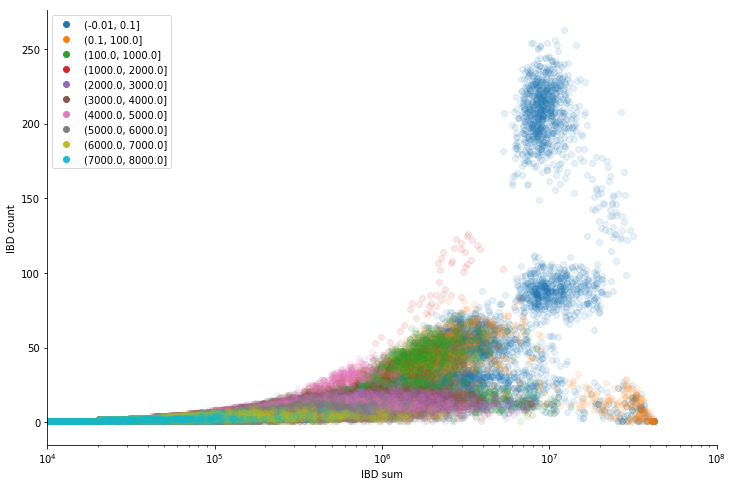

In [42]:
pal = iter(sns.palettes.color_palette(n_colors=n_bins))

f, ax = plt.subplots(figsize=(12, 8))
for x, frame in ds.groupby("distance_bin"):
    ax.scatter(x=frame.IBDsum, y=frame.IBDcount, c=next(pal), alpha=0.1, label=x)
    
ax.set_xscale("log")
ax.set_xlabel("IBD sum")
ax.set_ylabel("IBD count")
ax.set_xlim((10**4, 10**8))
sns.despine(ax=ax)
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)